In [ ]:
import tensorflow as tf
from tensorflow.contrib import rnn
import pickle
import csv, json
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import sys, os, time, shutil
import winsound
import re 
from IPython import display
import importlib
import html, string
import preprocess_twitter
from nltk.tokenize import sent_tokenize, TreebankWordTokenizer

reload preprocess_twitter.py if necessary

In [ ]:
importlib.reload(preprocess_twitter);

read user config

In [ ]:
with open('config.json') as json_config_file:
    user_config = json.load(json_config_file)
    data_path = user_config.get('data_path', os.getcwd())

change user config if necessary

In [ ]:
# user_config = {}
# user_config['data_path'] = r"<your_path_here>"

# with open('config.json', 'w') as json_config_file:
#     json.dump(user_config, json_config_file)

In [ ]:
vocab_size=int(1.2e6)
embedding_dim=200
classes = 8
assumed_max_length=70

read the word embedding

In [ ]:
word_dict_file = open(os.path.join(data_path, r"d" + str(embedding_dim) +"_word_embedding", "word_dict.pickle"), 'rb')
word_dict = pickle.load(word_dict_file)
word_dict2_file = open(os.path.join(data_path, r"d" + str(embedding_dim) +"_word_embedding", "word_dict2.pickle"), 'rb')
word_dict2 = pickle.load(word_dict2_file)

In [ ]:
word_embedding_file = open(os.path.join(data_path, r"d" + str(embedding_dim) +"_word_embedding", "word_embeddings_ndarray.pickle"), 'rb')
np_embedding = pickle.load(word_embedding_file)

## Preprocessing tweets

Some helper functions

In [ ]:
def remove_rt(txt):
    txt = txt.replace('RT','')
    return txt
    
def remove_link(txt):
    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', txt)
    for i in range(len(urls)):
        txt=txt.replace(urls[i],'')
    return txt
    
def remove_mentions(txt):
    mentions = re.findall(r'(?<=\W)[@]\S*', txt)
    for i in range(len(mentions)):
        txt=txt.replace(mentions[i],'')
    return txt
    
def remove_repeated_chars(txt):
    repeated_char= re.findall(r'((\w)\2{2,})',txt)
    for i  in range(len(repeated_char)):
        txt = txt.replace(repeated_char[i][0],repeated_char[i][1])
    return txt
    
def modify_lowercase_uppercase(txt):
    txt = txt.split(' ')
    for j in range(len(txt)):
        if not(txt[j].isupper()) and not(txt[j].islower()):
            txt[j] = txt[j].lower()
    tweet = ' '.join(txt )
    return tweet

def modify_all_lowercase(txt):
    return txt.lower()

def unescape_html(txt):
    return html.unescape(txt)

def split_punctuations(txt):
    txt = re.sub(r" *([^\w ']|( '|' |^'|'$)) *", r' \1 ', txt)
#     txt=re.sub(r"(((^|(?<=\s))')|('($|(?=\s))))", r' \1 ', sub0)
#     txt=re.sub(r" *([^\w ]) *", r' \1 ', txt)
    return txt

def split_emojis(txt):
    emojis='[\U0001F601-\U0001F64F\U00002702-\U000027B0\U0001F680-\U0001F6C0\U000024C2-\U0001F251\U0001F600-\U0001F636\U0001F681-\U0001F6C5\U0001F30D-\U0001F567]'
    return re.sub(r" *({}) *".format(emojis), r' \1 ', txt)

def replace_emojis(txt):
    txt=re.sub('[\U0000FE00-\U0000FE0F]', '', txt) #remove variation selectors
    txt=re.sub('[\U0001F3FB-\U0001F3FF]', '', txt) #remove color tones
    smile_ug = '[\U0001F603\U0001F604\U0001F600]'
    lolface_ug = '[\U0001F602\U0001F606]'
    sadface_ug = '[\U0001F614\U0001F616\U0001F622\U0001F625\U0001F629\U0001F62D\U0001F630\U0001F63F]'
    neutralface_ug = '[\U0001F610]'
    heart_ug = '[\U0001F60D\U0001F618\U0001F63B\U00002764\U0001F491-\U0001F49F]'
    txt = re.sub(smile_ug, " ᐸsmileᐳ ", txt)
    txt = re.sub(lolface_ug, " ᐸlolfaceᐳ ", txt)
    txt = re.sub(sadface_ug, " ᐸsadfaceᐳ ", txt)
    txt = re.sub(neutralface_ug, " ᐸneutralfaceᐳ ", txt)
    txt = re.sub(heart_ug, " ᐸheartᐳ ", txt)
    return txt

def split_others(txt):
    emojis='[\U0001F601-\U0001F64F\U00002702-\U000027B0\U0001F680-\U0001F6C0\U000024C2-\U0001F251\U0001F600-\U0001F636\U0001F681-\U0001F6C5\U0001F30D-\U0001F567]'
    txt = re.sub(r" *(( '|' |^'|'$)|[’.+…”“*]|{}) *".format(emojis), r' \1 ', txt)
    return txt

def multiclass_sentiment(line):
    sentiment_list = []
    for i in line[2:]:
        if i == '' or not i.isdigit() : continue
        sentiment_list.append(int(i) - 1)
    return sentiment_list

tokenizer = TreebankWordTokenizer()
def tweets_list_final(file_name, encoding):
    global count1, count2, count21, count3
    tweets_file = open(file_name,"r",encoding=encoding)
    tweets_csv_reader = csv.reader(tweets_file)
    init_tweet=np.array([-2 for _ in range(assumed_max_length)])
    for line in tweets_csv_reader:
        if len(line)<2 or line[1]=='' : continue
        for i in range(len(line[2:])):
            try:
                sent = int(line[2+i])
                break
            except ValueError:
                sent=0
        if sent==0: continue
        sentiments.append(sent - 1)
        sentiments_lists.append(multiclass_sentiment(line)) 
        
        tweet_np = np.copy(init_tweet)
        tweet = line[1]
        tweets_unprocessed.append(tweet)

        tweet1 = preprocess_twitter.tokenize(tweet)
        tweet1 = unescape_html(tweet1)
        tweet1 = split_punctuations(tweet1)
        tweet1 = split_emojis(tweet1)
        tweet1 = replace_emojis(tweet1)
#             tweet1 = split_others(tweet1)
        tweet1= tokenizer.tokenize(tweet1)
        tweet = tweet1

        tweets.append(tweet)
        for i in range(len(tweet)) :
#                 tweet_np[i] = word_dict.get(tweet[i],-1)
            tweet_np[i] = word_dict2.get(tweet[i],-1)

        tweets_indexed.append(tweet_np)
        
    tweets_file.close()

load tweets files and create a list for word-ids and a list for sentiments

In [ ]:
tweets = []
tweets_unprocessed = []
tweets_indexed = []
sentiments = []
sentiments_lists = []
tweets_list_final(os.path.join(data_path, "data_set0.csv"), "utf-8-sig")
tweets_list_final(os.path.join(data_path, "data_set1.csv"), "utf-8-sig")
tweets_list_final(os.path.join(data_path, "data_set2.csv"), "utf-8-sig")
#tweets_list_final(os.path.join(data_path, "data_set_a0.csv"), "utf-8-sig")

shuffle the tweets

In [ ]:
indices_shuffled = list(range(len(tweets)))
shuffle(indices_shuffled, lambda: 0)
tweets = [tweets[i] for i in indices_shuffled]
tweets_unprocessed = [tweets_unprocessed[i] for i in indices_shuffled]
tweets_indexed = [tweets_indexed[i] for i in indices_shuffled]
sentiments = [sentiments[i] for i in indices_shuffled]
sentiments_lists = [sentiments_lists[i] for i in indices_shuffled]

convert the list to np arrays

In [ ]:
tweets_np = np.array(tweets_indexed)
sents_np = np.array(sentiments, np.int16)
sents_mh_np = np.zeros((tweets_np.shape[0], classes), np.bool) #mh: multihot
sents_sc_np = np.zeros((tweets_np.shape[0], classes), np.float32) #sc: soft classes
for i in range(tweets_np.shape[0]):
    sents_mh_np[i, sentiments_lists[i]] = 1
priority_probs=[np.array([1]), np.array([2/3, 1/3]), np.array([3/6, 2/6, 1/6])]
for i in range(tweets_np.shape[0]):
    sc_indices = sentiments_lists[i]
    sents_sc_np[i, sc_indices] = priority_probs[len(sc_indices)-1]

some statistics on words that couldn't be embedded

In [ ]:
unmatched_words=tweets_np==-1
all_words=tweets_np>=-1
print('unmatched words:', round(np.count_nonzero(unmatched_words)/np.count_nonzero(all_words), 5))

In [ ]:
unknown_words = set()
unknown_words_l = []
for i in range(tweets_np.shape[0]):
    for j in range(tweets_np.shape[1]):
        if tweets_np[i,j]==-1:
            unknown_words.add(tweets[i][j])
            unknown_words_l.append(tweets[i][j])
print('Unknown words:')
# unknown_words
unknown_words_counts = []
unknown_words_dl = list(unknown_words)
for i in range(len(unknown_words_dl)):
    unknown_words_counts.append([unknown_words_l.count(unknown_words_dl[i]), unknown_words_dl[i]])
for item in sorted(unknown_words_counts, reverse=True):
    print('{}: {}'.format(item[0], item[1]))

get the maximum tweet length

In [ ]:
for i in range(assumed_max_length):
    if np.all(tweets_np[:,i]==-2):
        max_length=i+1; break; 
print('max_length:', max_length)

convert word-ids into the equivalent word embedding

In [ ]:
tweets_embedded = np.zeros((tweets_np.shape[0], tweets_np.shape[1], embedding_dim))
for i in range(tweets_np.shape[0]):
    tweet=tweets_np[i]
    for j in range(max_length):
        word_index=tweets_np[i,j]
        if word_index == -1: continue
        if word_index == -2: break
        tweets_embedded[i,j]=np_embedding[word_index]

dataset statistics

In [ ]:
print('data set size:', len(sents_np))
print('sent counts:', np.bincount(sents_np))
top_3_baseline = sum(sorted(np.bincount(sents_np), reverse=True)[:3])/sum(np.bincount(sents_np))
print('top 3-classses per all: {:.3}'.format(top_3_baseline))

### Some helper functions

In [ ]:
def iters_stats():
    latest_acc = 'train_acc: {:.3}\ttest_acc: {:.3}\n'.format(train_accs[-1], test_accs[-1])
    top_acc = 'top train_acc: {:.3}\ttop test_acc: {:.3}\n'.format(max(train_accs), max(test_accs))
    pass_test = 'passing test examples: {:.3}\n'.format(np.mean(tests_acc>0.5))
    test_acc2_o1 = np.argsort(iter_test_probs)[:,1] == sents_np[max_train:max_train + max_test]
    test_acc2_o2 = np.sum(np.minimum(iter_test_probs, sents_sc_np[max_train:max_train + max_test]), 1)
    test_acc2_f = np.mean(np.maximum(test_acc2_o1, test_acc2_o2))
    test_acc2 = 'test_acc2: {:.3}\n'.format(test_acc2_f)
    std_dev = 'standard deviation: {:.3}\n'.format(np.mean(np.std(iter_test_result, 0)))
    ex_time = "execution time: {:.3f} seconds".format(end_time - start_time)
    return (latest_acc + top_acc + pass_test + test_acc2 + std_dev + ex_time)
    
def iters_plot():
    set_plot()
    plt.show()
    
def set_plot():
    plt.gca().cla() 
    plt.plot(x_axis,train_accs[:(checkpoint)+1], label="train(bl=" + str(train_baseline) + ")")
    plt.plot(x_axis,test_accs[:(checkpoint)+1], label="test (bl=" + str(test_baseline) + ")")
    plt.title('Accuracy at iterations ({}:{})'.format(x_axis[0], x_axis[-1]))
    plt.legend(loc='best') #upper left    

sent_map=['Happy','Love','Hopeful','Neutral','Angry','Hopeless','Hate','Sad']
def tweets_with_results(group ='wrong', processed = False):
    text = ''
    for i in range(max_test):
#         if tests_acc[i]==False:
        item_acc = np.sum(tests_acc[i])/np.sum(sents_sc_np[max_train+i])
        condition = True
        if group == 'wrong': condition = item_acc<0.5
        if group == 'correct': condition = item_acc>=0.5
        if condition:
            if processed: tweet_p = ' '.join(tweets[max_train+i])
            else: tweet_p = tweets_unprocessed[max_train+i]
            res_p=', '.join(['{}: {:.3}'.format(sent_map[l], iter_test_probs[i, l]) for l in np.argsort(iter_test_probs[i])[::-1][:3] if iter_test_probs[i, l]>0.01])
            targets_p=', '.join([sent_map[j] for j in sentiments_lists[max_train+i]])
#             probs_p=[float('{:.3}'.format(k)) for k in iter_test_probs[i]]
            text += tweet_p + '\n> ' + res_p + " >> " + targets_p + '\n'
    return text

def log_iters():
    log_folder = os.path.join(data_path, 'log', "{}_tr{}te{}_u{}l{}do{}d{}_{}".format(iters_label, max_train, max_test, num_units, num_layers, drop_out, embedding_dim, session_init_time))
    set_plot()
    if not os.path.exists(log_folder): os.makedirs(log_folder)
    log_file_name = os.path.join(log_folder, "i{}-{}".format(x_axis[0], x_axis[-1]))
    plt.savefig(log_file_name + '.svg');
    plt.savefig(log_file_name + '.png');
    plt.close()
    with open(log_file_name + '.txt', 'w') as log_file: log_file.write(iters_stats())
    with open(log_file_name + '_rejected.txt', 'w', encoding = 'utf-8') as log_file: log_file.write(tweets_with_results())
    with open(log_file_name + '_approved.txt', 'w', encoding = 'utf-8') as log_file: log_file.write(tweets_with_results(group = 'correct'))
    if iters==total_iters: shutil.copy2(os.path.join(os.getcwd(), 'Model Si.ipynb'), log_folder)
        
def save_session():
    saver = tf.train.Saver()
    sess_name='TA{:.3}-{:.3}_{}_tr{}te{}_u{}l{}do{}d{}'.format(test_accs[-1], max(test_accs), iters_label, max_train, max_test, num_units, num_layers, drop_out, embedding_dim)
    sess_folder = os.path.join(data_path, 'Sessions', sess_name)
    if not os.path.exists(sess_folder): os.makedirs(sess_folder)
    saver.save(sess, os.path.join(sess_folder, iters_label))
    shutil.copy2(os.path.join(os.getcwd(), 'Model Si.ipynb'), sess_folder)

# Graph

In [ ]:
num_units = 200
num_layers = 1
drop_out = 0.0
batch_size = 100
num_steps = max_length

In [85]:
tf.reset_default_graph()
tf.set_random_seed(0)
use_dropout = tf.constant(True)
# embedding = tf.Variable(tf.constant(0, dtype=tf.float16, shape=(vocab_size, embedding_dim)), trainable=False, name='embedding')
inputs = tf.placeholder(tf.float32, (batch_size, num_steps, embedding_dim))
inputs_d = tf.nn.dropout(inputs, 1-drop_out)
inputs_c = tf.cond(use_dropout, lambda: inputs_d, lambda: inputs)
# targets = tf.placeholder(tf.int32, (batch_size,))
targets_mc = tf.placeholder(tf.float32, (batch_size, classes))

softmax_w = tf.Variable(tf.random_uniform((num_units, classes), 0.0001, 0.001))
softmax_b = tf.Variable(tf.random_uniform((classes,), 0.0001, 0.001))

cell = rnn.BasicLSTMCell(num_units)
cell_m = tf.contrib.rnn.MultiRNNCell([cell] * num_layers)
all_outputs, final_states = tf.nn.dynamic_rnn(cell_m, inputs_c, dtype=tf.float32)
outputs = all_outputs[:,-1]

# targets_oh = tf.one_hot(targets, classes, on_value=1, off_value=0)

logits = tf.matmul(outputs, softmax_w) + softmax_b
probs = tf.nn.softmax(logits)
results = tf.nn.top_k(probs, 3).indices
# probs = tf.nn.sigmoid(logits)
# results = probs>0.5

# losses=tf.reduce_sum(tf.square(tf.subtract(tf.cast(targets_oh, tf.float16), tf.cast(probs, tf.float16))))
# losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits)
# losses = -tf.reduce_sum(targets_mc * tf.log(tf.clip_by_value(probs, 1e-10, 1.0)))
# losses=tf.reduce_sum(tf.square(tf.subtract(targets_mc, probs)))
losses=tf.reduce_sum(tf.square(tf.nn.relu(tf.subtract(targets_mc, probs))))
# losses = tf.nn.softmax_cross_entropy_with_logits(labels=targets_mc, logits=logits)

opt = tf.train.AdamOptimizer()
opt_op = opt.minimize(losses)

# fw=tf.summary.FileWriter('TFSums', tf.get_default_graph())
# fw.flush()
# graph_runs = 0

# Session

In [92]:
iters=500;
max_train=1600; max_test = 400;
iters_label = "ModelSi-RELU-PF"

train_baseline=np.round(np.max(np.bincount(sents_np[:max_train]))/max_train, 3)
test_baseline=np.round(np.max(np.bincount(sents_np[max_train:max_train+max_test]))/max_test, 3)

train_accs = np.zeros(iters//5+1)
test_accs = np.zeros(iters//5+1)
iter_train_probs = np.zeros((max_train, classes))
iter_test_probs = np.zeros((max_test, classes))
iter_train_result = np.zeros((max_train, classes), np.bool)
iter_test_result = np.zeros((max_test, classes), np.bool)

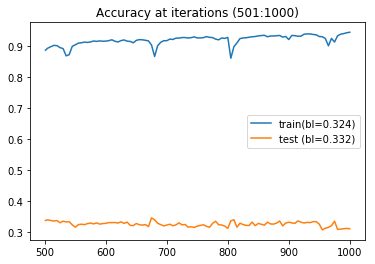

train_acc: 0.945	test_acc: 0.31
top train_acc: 0.945	top test_acc: 0.345
passing test examples: 0.31
test_acc2: 0.388
standard deviation: 0.419
execution time: 5487.911 seconds


In [93]:
start_time = time.time()

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# total_iters=0; session_init_time='UTC'+time.strftime("%y%m%d-%H%M%S", time.gmtime())

# saver = tf.train.Saver()
# saver.restore(sess, os.path.join(data_path, "d"+ str(embedding_dim), "_word_embedding", "TF_Variables")

x_axis=[]
for i in range(iters):
    checkpoint = None
    if (i+1)%5 == 0: checkpoint = (i+1)//5 
    if i==0: checkpoint=0
    
    # Train the model and get train results
    for train in range(int(max_train/batch_size)):
        np_inputs = tweets_embedded[train*batch_size:(train+1)*batch_size, :num_steps]
        np_targets = sents_sc_np[train*batch_size:(train+1)*batch_size]
        if checkpoint is not None:
            _, np_probs, np_results = sess.run([opt_op, probs, results], feed_dict={inputs: np_inputs, targets_mc: np_targets})
#             iter_train_result[train*batch_size:(train+1)*batch_size] = np.eye(classes)[np_results.squeeze()] #one_hot
            iter_train_result[np.arange(train*batch_size,(train+1)*batch_size)[:, np.newaxis], np_results] = True
            iter_train_probs[train*batch_size:(train+1)*batch_size] = np_probs
        else:
            _ = sess.run([opt_op], feed_dict={inputs: np_inputs, targets_mc: np_targets})

    # Collect and present data or go to the next iteration
    if checkpoint is None: continue

    # Get test results
    for test in range(int(max_test/batch_size)):
        np_test_inputs = tweets_embedded[max_train + (test*batch_size):max_train + ((test+1)*batch_size), :num_steps]
        np_test_targets = sents_sc_np[max_train + (test*batch_size):max_train + ((test+1)*batch_size)]
        np_test_results, np_test_probs = sess.run([results, probs], feed_dict={inputs:  np_test_inputs, targets_mc: np_test_targets, use_dropout: False})
        iter_test_probs[(test*batch_size):((test+1)*batch_size)] = np_test_probs
        iter_test_result[np.arange((test*batch_size),((test+1)*batch_size))[:, np.newaxis], np_test_results] = True
        
    # Calculate train accuracy
#     train_acc = np.fromiter(map(lambda i,j :i in j, iter_train_result, sentiments_lists[:max_train]), dtype=np.bool)
#     train_acc = iter_train_result == sents_mh_np[:max_train]
#     train_acc = np.any(np.logical_and(iter_train_result, sents_mh_np[:max_train]), 1)
    train_acc = np.sum(np.minimum(iter_train_probs, sents_sc_np[:max_train]), 1)
    train_accs[checkpoint] = np.mean(train_acc)
   
    # Calculate test accuracy
#     tests_acc = np.fromiter(map(lambda i,j :i in j, iter_test_result, sentiments_lists[max_train:max_train + max_test]), dtype=np.bool)
#     tests_acc = iter_test_result == sents_mh_np[max_train:max_train + max_test]
#     tests_acc = np.any(np.logical_and(iter_test_result, sents_mh_np[max_train:max_train + max_test]), 1)
    tests_acc = np.sum(np.minimum(iter_test_probs, sents_sc_np[max_train:max_train + max_test]), 1)
    test_accs[checkpoint] = np.mean(tests_acc)
    
    # Update the plot    
    x_axis.append(total_iters + i+1)
    plt.gca().cla() 
    plt.plot(x_axis,train_accs[:(checkpoint)+1], label="train(bl=" + str(train_baseline) + ")")
    plt.plot(x_axis,test_accs[:(checkpoint)+1], label="test (bl=" + str(test_baseline) + ")")
    plt.title('Accuracy at iterations ({}:{})'.format(x_axis[0], x_axis[-1]))
    plt.legend(loc='best') #upper left
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
total_iters+=iters
end_time=time.time()
plt.close() #close the plot since it's already been displayed

# iters_plot()
print(iters_stats())
log_iters()
winsound.Beep(2500,500)

In [94]:
save_session()

### Wrong results

In [ ]:
print(tweets_with_results())

processed tweets

In [ ]:
print(tweets_with_results(processed = True))